In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 24.6 MB/s eta 0:00:00


In [2]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/Othkkartho/abuse_division/master/data/origin_final.csv", filename="dataset.csv")

('dataset.csv', <http.client.HTTPMessage at 0x7f45b4315e40>)

In [5]:
total_data = pd.read_csv('dataset.csv', encoding = "utf-8")
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 5825


In [6]:
total_data[:5]

,text,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1


In [7]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 4368
테스트용 리뷰의 개수 : 1457


<Axes: >

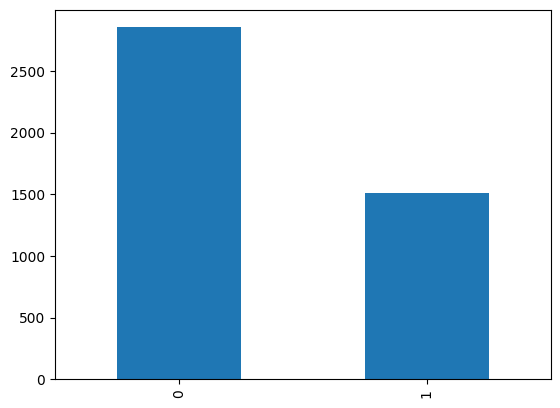

In [8]:
train_data['label'].value_counts().plot(kind = 'bar')

In [9]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   2854
1      1   1514


In [10]:
# 한글과 공백을 제외하고 모두 제거
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
#train_data['text'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

text     0
label    0
dtype: int64


<ipython-input-10-ab6011aefac3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [11]:
test_data.drop_duplicates(subset = ['text'], inplace=True) # 중복 제거
test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
#test_data['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 1454


<ipython-input-11-428751208323>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [12]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [13]:
okt = Okt() 

train_data['tokenized'] = train_data['text'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['text'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [14]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [15]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 145), ('으로', 140), ('로', 140), ('에서', 138), ('ㅋㅋ', 115), ('나', 109), ('말', 107), ('그', 105), ('못', 104), ('저', 102), ('사람', 97), ('때', 91), ('거', 89), ('하는', 84), ('ㅋㅋㅋ', 83), ('하고', 82), ('그냥', 77), ('돈', 75), ('내', 74), ('생각', 73)]


In [16]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('새끼', 298), ('아', 152), ('병신', 142), ('존나', 140), ('로', 126), ('으로', 120), ('에서', 114), ('안', 112), ('못', 109), ('ㅋㅋ', 105), ('나', 102), ('하고', 101), ('하는', 101), ('개', 100), ('야', 97), ('거', 90), ('년', 88), ('좆', 87), ('저', 86), ('ㅋㅋㅋ', 85)]


긍정 리뷰의 평균 길이 : 15.202774108322325
부정 리뷰의 평균 길이 : 8.420112123335668


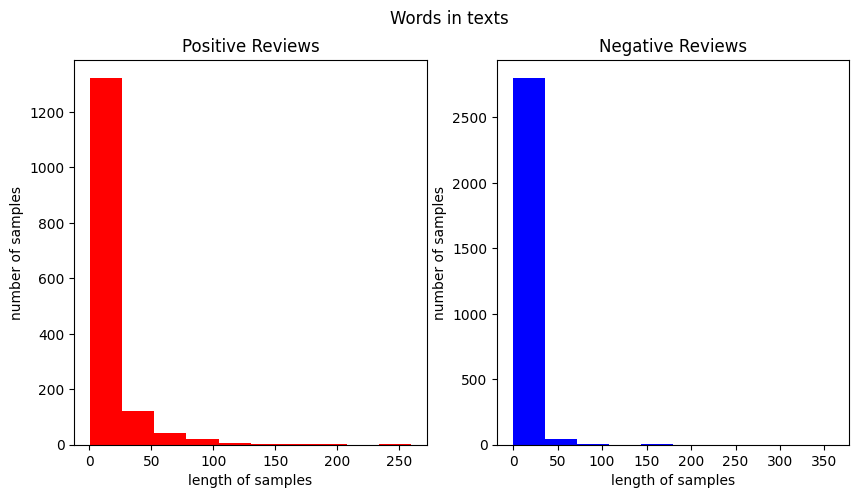

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [18]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 13970
등장 빈도가 1번 이하인 희귀 단어의 수: 9111
단어 집합에서 희귀 단어의 비율: 65.21832498210452
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 19.365329025675905


In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4861


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 360
리뷰의 평균 길이 : 10.771062271062272


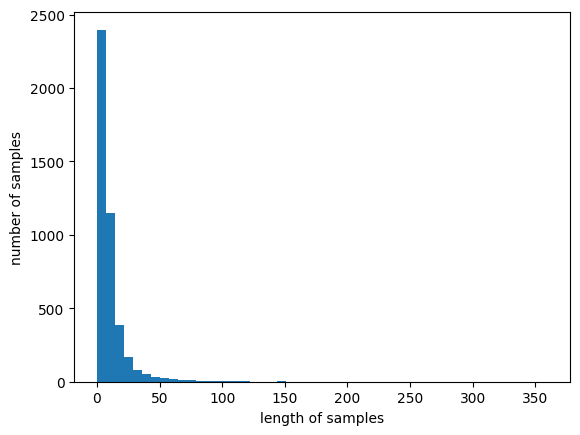

In [23]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [25]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 98.42032967032966


In [26]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [28]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

In [29]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('CNN_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 0.0428 - acc: 0.9871
Epoch 1: val_acc improved from 0.84044 to 0.99199, saving model to CNN_best_model.h5
28/28 [==============================] - 12s 353ms/step - loss: 0.0428 - acc: 0.9871 - val_loss: 0.0377 - val_acc: 0.9920
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.9934
Epoch 2: val_acc did not improve from 0.99199
28/28 [==============================] - 9s 330ms/step - loss: 0.0245 - acc: 0.9934 - val_loss: 0.0504 - val_acc: 0.9863
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.0197 - acc: 0.9940
Epoch 3: val_acc did not improve from 0.99199
28/28 [==============================] - 9s 320ms/step - loss: 0.0197 - acc: 0.9940 - val_loss: 0.0610 - val_acc: 0.9817
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 0.0169 - acc: 0.9951
Epoch 4: val_acc did not improve from 0.99199
28/28 [==============================] - 9s 333ms/step - 

In [42]:
loaded_model = load_model('CNN_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

46/46 [==============================] - 1s 27ms/step - loss: 0.7930 - acc: 0.8136

 테스트 정확도: 0.8136


In [43]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 부정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format((1 - score) * 100))

In [44]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 [==============================] - 0s 74ms/step
100.00% 확률로 부정 리뷰입니다.


In [45]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 [==============================] - 0s 22ms/step
96.00% 확률로 긍정 리뷰입니다.


In [46]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 [==============================] - 0s 22ms/step
55.40% 확률로 부정 리뷰입니다.
